# Dynamics of the Double Pendulum

This notebook provides a simple example of simulating the dynamics of a double pendulum, and examining the equations of motion in manipulator form.

## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [1]:
try:
  import pydrake
  import underactuated
except ImportError:
  !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
  from jupyter_setup import setup_underactuated
  setup_underactuated()

## Running a simulation

<IPython.core.display.Javascript object>


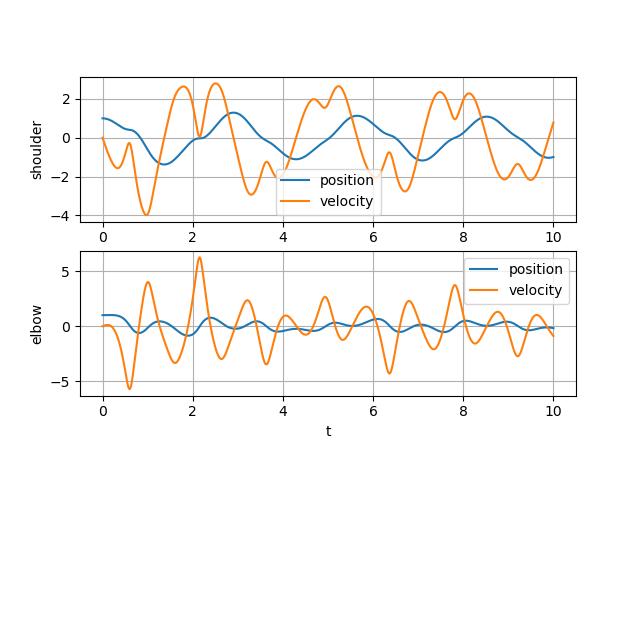

In [2]:
# This cell sets up a double pendulum, runs a simulation, and
# renders a video of its results.
import matplotlib.pyplot as plt

from pydrake.all import (AddMultibodyPlantSceneGraph,
                         DiagramBuilder,
                         Parser,
                         PlanarSceneGraphVisualizer,
                         Simulator,
                         SignalLogger)
from underactuated import FindResource
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

# Set up a block diagram with the robot (dynamics) and a visualization block.
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)

# Load the double pendulum from Universal Robot Description Format
parser = Parser(plant, scene_graph)
parser.AddModelFromFile(FindResource("models/double_pendulum.urdf"))
plant.Finalize()

builder.ExportInput(plant.get_actuation_input_port())
visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph,
                                                          xlim=[-2.8, 2.8],
                                                          ylim=[-2.8, 2.8],
                                                          show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))

# The logger needs to be told to expect a 4-element input
# (the 4-element double pendulum state, in this case).
logger = builder.AddSystem(SignalLogger(4))
logger.DeclarePeriodicPublish(0.033333, 0.0)
builder.Connect(plant.get_state_output_port(), logger.get_input_port(0))

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)

# Set the initial conditions
context = simulator.get_mutable_context()
context.SetContinuousState([1., 1., 0., 0.])  # (theta1, theta2, theta1dot, theta2dot)
context.FixInputPort(0, [0.,0.])   # Zero input torques

# Simulate and animate
AdvanceToAndVisualize(simulator, visualizer, 10.0)

In [4]:
# Run this cell after running a simulation to plot traces
# of the pendulum state across time.
fields = ["shoulder", "elbow"]
for i in range(2):
    plt.subplot(3, 1, i+1)
    plt.plot(logger.sample_times(), logger.data()[(i, i+2), :].transpose())
    plt.legend(["position", "velocity"])
    plt.xlabel('t')
    plt.ylabel(fields[i])
    plt.grid(True)
    plt.show()

It's worth taking a peek at the [file that describes the robot](https://github.com/RussTedrake/underactuated/blob/master/underactuated/models/double_pendulum.urdf). URDF and SDF are two of the standard formats, and they can be used to describe even very complicated robots (like the Boston Dynamics humanoid).

## Inspecting the dynamics (the manipulator equations)

We can also use Drake to evaluate the manipulator equations.  First we will evaluate the manipulator equations for a particular robot (with numerical values assigned for mass, link lengths, etc) and for a particular state of the robot.


In [ ]:
from pydrake.all import MultibodyPlant
from underactuated import ManipulatorDynamics

plant = MultibodyPlant(time_step=0)
parser = Parser(plant)
parser.AddModelFromFile(FindResource("models/double_pendulum.urdf"))
plant.Finalize()

# Evaluate the dynamics numerically
q = [0.1, 0.1]
v = [1, 1]
(M, Cv, tauG, B, tauExt) = ManipulatorDynamics(plant, q, v)
print("M = \n" + str(M))
print("Cv = " + str(Cv))
print("tau_G = " + str(tauG))
print("B = " + str(B))
print("tau_ext = " + str(tauExt))

Drake is also fairly unique in supporting symbolic computation (with floating point coefficients).  Here is an example of printing out the symbolic dynamics of the double pendulum.  (If you've ever written out the equations of your robot, you know they get complicated quickly!)

In [ ]:
from pydrake.all import Variable

# Evaluate the dynamics symbolically
q = [Variable("theta0"), Variable("theta1")]
v = [Variable("thetadot0"), Variable("thetadot1")]
(M, Cv, tauG, B, tauExt) = ManipulatorDynamics(plant.ToSymbolic(), q, v)
print("M = \n" + str(M))
print("Cv = " + str(Cv))
print("tau_G = " + str(tauG))
print("B = " + str(B))
print("tau_ext = " + str(tauExt))

We use a similar mechanisms to support automatic differentiation; we'll see examples of that soon!